In [1]:
import time


from datetime import date
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from itertools import combinations, product
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV,GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler,RobustScaler,MaxAbsScaler,StandardScaler,OneHotEncoder, OrdinalEncoder
#evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,mean_absolute_percentage_error

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

#storing and loading 
import pickle
import json



In [2]:
path = r"C:\Users\acer\Desktop\Data Science\Prodigy Infotech\Mall_Customers.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.isnull().sum()


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
new_df = df.drop('CustomerID', axis=1)


In [7]:
new_df.head(10)


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
5,Female,22,17,76
6,Female,35,18,6
7,Female,23,18,94
8,Male,64,19,3
9,Female,30,19,72


In [8]:
new_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


In [9]:
new_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [10]:
numerical_features = new_df.select_dtypes(exclude = ['object']).columns.tolist()
categorical_featrues = new_df.select_dtypes(exclude = ['object']).columns.tolist()

In [11]:
new_df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [12]:
df1 = new_df.copy()
df1['Gender'] = df1['Gender'].map({'Male':1, 'Female':0})

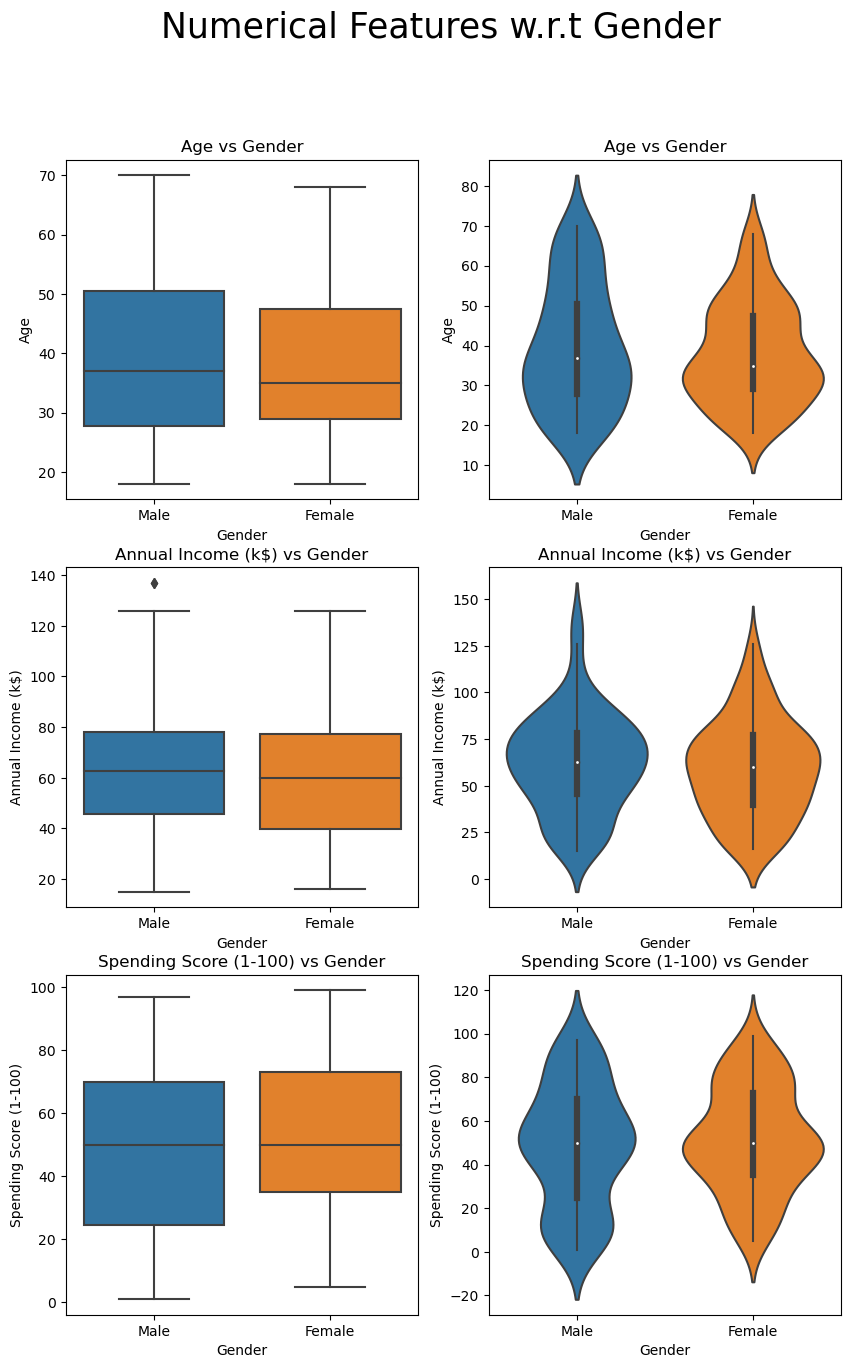

In [13]:
fig, axes = plt.subplots(nrows = 3, ncols = 2,figsize = (10,15))
for i, j in enumerate(numerical_features):
    ax = sns.boxplot(x = 'Gender',y = j, data = df, ax = axes[i, 0])
    title = j + ' vs Gender'
    axes[i, 0].set_title(title)
    
    ax = sns.violinplot(x = 'Gender',y = j, data = df, ax = axes[i, 1])
    title = j + ' vs Gender'
    axes[i, 1].set_title(title)
fig.suptitle('Numerical Features w.r.t Gender', fontsize = 25)
plt.show()

In [14]:
comb = list(combinations(numerical_features, 2))
print(comb)

[('Age', 'Annual Income (k$)'), ('Age', 'Spending Score (1-100)'), ('Annual Income (k$)', 'Spending Score (1-100)')]


In [15]:
df1.skew()

Gender                    0.243578
Age                       0.485569
Annual Income (k$)        0.321843
Spending Score (1-100)   -0.047220
dtype: float64

In [16]:
data_to_normalize = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_MinMax_df = pd.DataFrame(normalized_data, columns=data_to_normalize.columns)


In [17]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_Zscore_df = pd.DataFrame(normalized_data, columns=data_to_normalize.columns)

In [18]:
def tracer(db, clu, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db[clu]==n]['Age'],
        y = db[db[clu]==n]['Spending Score (1-100)'],
        z = db[db[clu]==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(size = 5)
     )

def plot_silhouette(X, clusters):
    silhouette_avg = silhouette_score(X, clusters)
    sample_silhouette_values = silhouette_samples(X, clusters)
    y_lower = 10
    for i in range(len(set(clusters))):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / len(set(clusters)))
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    plt.title("Silhouette plot for the clusters")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.show()

In [20]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(normalized_MinMax_df)
    wcss.append(kmeans.inertia_)
print(wcss)

[37.401482160359436, 22.56077488260975, 17.371946164404168, 12.650287676229912, 10.303964892534122, 8.385099035848986, 7.463483575199629, 6.248886770318165, 5.483963011692648, 5.03257105087774]


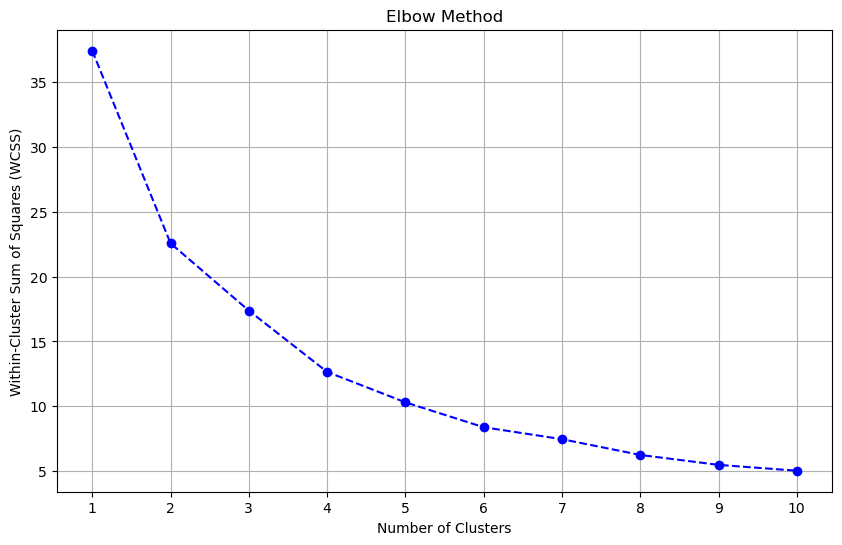

In [21]:
plt.figure(figsize=(10, 6)) 
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')  
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))  
plt.grid(True) 
plt.show()

In [22]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(normalized_Zscore_df)
    wcss.append(kmeans.inertia_)
print(wcss)

[600.0, 389.3861889564371, 295.2122461555489, 205.22514747675916, 168.24758017556837, 133.86842085478855, 120.43283250037277, 103.81525583671635, 92.34945767113052, 82.88526644450906]


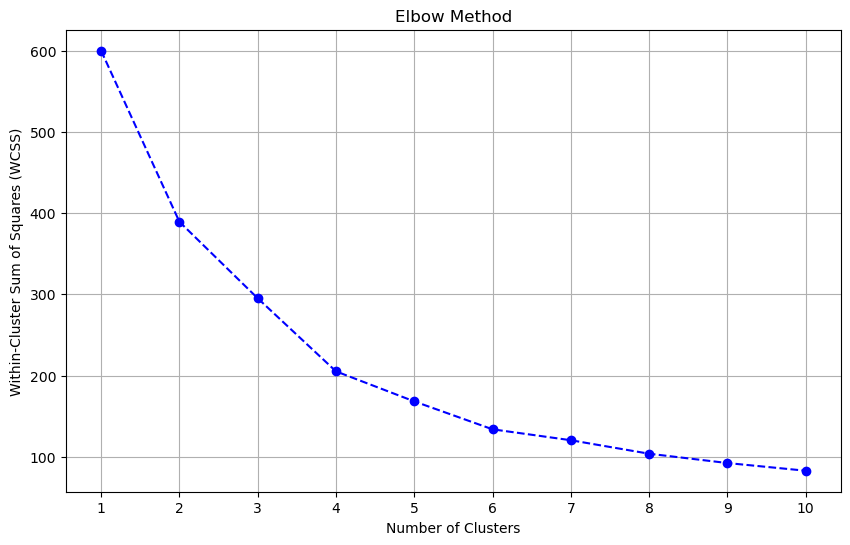

In [23]:
plt.figure(figsize=(10, 6)) 
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')  
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))  
plt.grid(True) 
plt.show()

In [24]:
df_clusters = df1.copy()


In [25]:
km_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(df1) # initialise and fit K-Means model
df_clusters.loc[:,'KMeans5'] = km_5_clusters.labels_ # append labels to points

In [26]:
X = df.drop(columns=['CustomerID', 'Age'], axis=1).values

In [27]:
X = df.drop(columns=['CustomerID', 'Age', 'Gender'], axis=1).values


In [28]:
cluster = AgglomerativeClustering(n_clusters=5, metric="euclidean",linkage="ward")
labels_= cluster.fit_predict(df_clusters)

In [29]:
labels_


array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 0, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1,
       0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1], dtype=int64)

In [31]:
silhouette_scores = {}

silhouette_scores['Agglomerative'] = silhouette_score(df_clusters, labels_)


silhouette_scores['KMeans'] = silhouette_score(df_clusters, km_5_clusters.labels_)

for algorithm, score in silhouette_scores.items():
    print(f"Silhouette Score for {algorithm} Clustering: {score}")

Silhouette Score for Agglomerative Clustering: 0.4404778774858964
Silhouette Score for KMeans Clustering: 0.44475633417325083


In [36]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
cluster_agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_agg = cluster_agg.fit_predict(df_clusters)

kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(df_clusters)
labels_kmeans = kmeans.labels_

silhouette_scores_initial = {'Agglomerative': silhouette_score(df_clusters, labels_agg), 'KMeans': silhouette_score(df_clusters, labels_kmeans)}
print("Initial Silhouette Scores:")
for algorithm, score in silhouette_scores_initial.items():
    print(f"Silhouette Score for {algorithm} Clustering: {score}")
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clusters)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
cluster_agg_tuned = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_agg_tuned = cluster_agg_tuned.fit_predict(df_pca)
kmeans_tuned = KMeans(n_clusters=5, init='k-means++')
kmeans_tuned.fit(df_pca)
labels_kmeans_tuned = kmeans_tuned.labels_

silhouette_scores_tuned = {
    'Agglomerative': silhouette_score(df_pca, labels_agg_tuned),'KMeans': silhouette_score(df_pca, labels_kmeans_tuned)
}
print("\nSilhouette Scores after Tuning:")
for algorithm, score in silhouette_scores_tuned.items():
    print(f"Silhouette Score for {algorithm} Clustering: {score}")


Initial Silhouette Scores:
Silhouette Score for Agglomerative Clustering: 0.4404778774858964
Silhouette Score for KMeans Clustering: 0.44475633417325083

Silhouette Scores after Tuning:
Silhouette Score for Agglomerative Clustering: 0.41038556176060664
Silhouette Score for KMeans Clustering: 0.44359471020836977
